# Perihelion advance of Mercury

The GR evolution of the orbit of a low mass object near a more massive object is:

$$\ddot{\bf r} = - \frac{c^2}{2} \frac{r_s}{r^2}\left [ 1 + 3 \left ( \frac{l}{cr} \right )^2 \right ] \frac{{\bf r}}{r}$$

where $l$ is the specific angular momentum and $r_s$ is the Schwarzchild radius of the Sun:

$$r_s = \frac{2 GM_\odot}{c^2}$$

see, e.g., [Körber et al. 2018](https://arxiv.org/pdf/1803.01678).

We can start with Mercury at perihelion, where ${\bf r}$ and $\dot{\bf r}$ are perpendicular.  Then

* $\dot{\bf r}_0 = 5.9\times 10^6~\mathrm{cm/s}$
* ${\bf r}_0 = 4.6\times 10^{12}~\mathrm{cm}$
* $l = |{\bf r}_0||\dot{\bf r}_0|$

We will write our system in terms of $x$, $y$, $u$, $v$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class OrbitState:
    # a container to hold the Mercury's position
    def __init__(self, x, y, u, v):
        self.x = x
        self.y = y
        self.u = u
        self.v = v

    def __add__(self, other):
        return OrbitState(self.x + other.x, self.y + other.y,
                          self.u + other.u, self.v + other.v)

    def __sub__(self, other):
        return OrbitState(self.x - other.x, self.y - other.y,
                          self.u - other.u, self.v - other.v)

    def __mul__(self, other):
        return OrbitState(other * self.x, other * self.y,
                          other * self.u, other * self.v)

    def __rmul__(self, other):
        return self.__mul__(other)

    def __str__(self):
        return f"{self.x:10.6f} {self.y:10.6f} {self.u:10.6f} {self.v:10.6f}"

In [65]:
class OrbitsRK4:
    """ model the evolution of a single planet around the Sun"""

    def __init__(self, rad_p=4.6e12, vel_p=5.9e6, *, beta=3):

        # physical constants
        self.G = 6.67e-8
        self.c = 3.e10
        self.M_sun = 2.e33

        # coefficient of the GR correction
        self.beta = beta

        # assume we are at perihelion
        self.r_l = rad_p * vel_p / self.c
        self.r_s_csq = 2.0 * self.G * self.M_sun
        
        self.history = [OrbitState(rad_p, 0.0, 0.0, vel_p)]
        self.time = [0.0]

        self.n_reset = None

    def npts(self):
        """ return the number of integration points"""
        return len(self.time)

    def get_time(self, n):
        """ return the time corresponding to step n"""
        return self.time[n]

    def rhs(self, state):
        """ RHS of the equations of motion."""
        
        # current radius
        r = np.sqrt(state.x**2 + state.y**2)

        # position
        xdot = state.u
        ydot = state.v

        # velocity
        udot = -0.5 * self.r_s_csq / r**2 * (1 + self.beta * (self.r_l/r)**2) * state.x / r
        vdot = -0.5 * self.r_s_csq / r**2 * (1 + self.beta * (self.r_l/r)**2) * state.y / r        

        return OrbitState(xdot, ydot, udot, vdot)

    def single_step(self, state_old, dt):
        """ take a single RK-4 timestep from t to t+dt for the system
        ydot = rhs """

        # get the RHS at several points
        ydot1 = self.rhs(state_old)

        state_tmp = state_old + 0.5 * dt * ydot1
        ydot2 = self.rhs(state_tmp)

        state_tmp = state_old + 0.5 * dt * ydot2
        ydot3 = self.rhs(state_tmp)

        state_tmp = state_old + dt * ydot3
        ydot4 = self.rhs(state_tmp)

        # advance
        state_new = state_old + (dt / 6.0) * (ydot1 + 2.0 * ydot2 +
                                              2.0 * ydot3 + ydot4)

        return state_new

    def integrate(self, dt_in, err, tmax):
        """ integrate the equations of motion using 4th order R-K method with an
            adaptive stepsize, to try to achieve the relative error err.  dt
            here is the initial timestep
            """

        S1 = 0.9
        S2 = 4.0

        # start with the old timestep
        dt_new = dt_in
        dt = dt_in

        n_reset = 0
        t = 0

        while t < tmax:

            state_old = self.history[-1]

            if err > 0.0:

                # adaptive stepping iteration loop -- keep trying to take a step
                # until we achieve our desired error

                rel_error = 1.e10

                n_try = 0
                while rel_error > err:
                    dt = dt_new
                    if t+dt > tmax:
                        dt = tmax-t

                    # take 2 half steps
                    state_tmp = self.single_step(state_old, 0.5*dt)
                    state_new = self.single_step(state_tmp, 0.5*dt)

                    # now take just a single step to cover dt
                    state_single = self.single_step(state_old, dt)

                    # state_new should be more accurate than state_single since it
                    # used smaller steps

                    # estimate the relative error now

                    rel_error = max(abs((state_new.x - state_single.x) / state_single.x),
                                    abs((state_new.y - state_single.y) / state_single.y),
                                    abs((state_new.u - state_single.u) / state_single.u),
                                    abs((state_new.v - state_single.v) / state_single.v))

                    # adaptive timestep algorithm for RK4

                    dt_est = dt * abs(err/rel_error)**0.2
                    dt_new = min(max(S1*dt_est, dt/S2), S2*dt)

                    n_try += 1

                if n_try > 1:
                    # n_try = 1 if we took only a single try at the step
                    n_reset += (n_try-1)

            else:

                # take just a single step
                if t + dt > tmax:
                    dt = tmax - t

                # take just a single step to cover dt
                state_new = self.single_step(state_old, dt)

            # successful step
            t += dt

            # store
            self.time.append(t)
            self.history.append(state_new)

    def plot(self, points=False):
        """plot the orbit"""
        fig, ax = plt.subplots()
        x = [q.x for q in self.history]
        y = [q.y for q in self.history]

        # draw the Sun
        ax.scatter([0], [0], marker=(20,1), color="y", s=250)

        if points:
            ax.scatter(x, y)
        else:
            ax.plot(x, y)
        ax.set_aspect("equal")
        return fig


In [88]:
o = OrbitsRK4(beta=1000000)

In [89]:
P = 7.6e6   # Mercury's period in s
dt_init = P/20

In [90]:
o.integrate(dt_init, 1.e-8, 10*P)

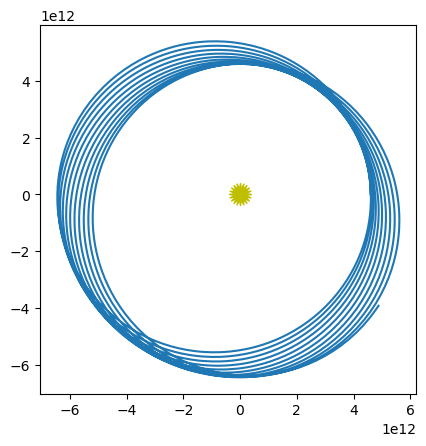

In [91]:
fig = o.plot()

In [70]:
o.r_s_csq / o.c**2

296444.4444444444

In [71]:
o.r_l

904666666.6666666